In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold, preprocessing
from sklearn.neural_network import MLPClassifier
import math
import copy
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

plt.style.use("seaborn-v0_8")
sns.set(color_codes=True)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

seed = 10
workshop_paper_path = "../../../Latex_projects/ECML_PKDD_XKDD_workshop_paper/figures/"

In [2]:
# Generate synthetic dataset

def create_synthetic_dataset(num_points_top, num_points_left, num_points_middle, num_points_right):
    np.random.seed(seed)
    num_features = 2
    
    # top cluster
    mu_top = [0.2, 0.7]
    sigma_top = [0.1, 0.1]
    # num_points_top = 100
    cluster_top_X = np.random.normal(mu_top, sigma_top, (num_points_top, num_features))
    cluster_top_y = np.zeros(num_points_top)
    
    # left cluster    
    mu_left = [0.15, 0.3]
    sigma_left = [0.1, 0.1]
    # num_points_bottom = 100
    cluster_left_X = np.random.normal(mu_left, sigma_left, (num_points_left, num_features))
    cluster_left_y = np.ones(num_points_left)
    
    # middle cluster
    mu_middle = [0.5, 0.4]
    sigma_middle = [0.1, 0.1]
    # num_points_middle = 50
    cluster_middle_X = np.random.normal(mu_middle, sigma_middle, (num_points_middle, num_features))
    cluster_middle_y = np.ones(num_points_middle)

    # right vertical cluster
    mu_right = [0.7, 0.7]
    sigma_right = [0.1, 0.1]
    # num_points_right = 150
    cluster_right_X = np.random.normal(mu_right, sigma_right, (num_points_right, num_features))
    cluster_right_y = np.ones(num_points_right)

    X = np.concatenate((cluster_top_X, cluster_left_X, cluster_middle_X, cluster_right_X), axis=0)
    y = np.concatenate((cluster_top_y, cluster_left_y,  cluster_middle_y, cluster_right_y))

    df = pd.DataFrame(preprocessing.minmax_scale(X), columns=["x1", "x2"])
    df["y"] = y

    return df

In [3]:
num_points_top = 100
num_points_left = 70
num_points_middle = 70
num_points_right = 70

df = create_synthetic_dataset(num_points_top, num_points_left, num_points_middle, num_points_right)

In [23]:
def plot_counterfactual_explanations(ax, df, predictor, node_paths, color_bar = True):
    # fig, ax = plt.subplots(figsize=(7,6))

    ax = plot_dataset(ax, df)
    X = df[["x1", "x2"]]
    ax = plot_decision_boundary(ax, X, predictor, color_bar = color_bar)
    # plot_counterfactual_candidates(ax, X, sorted_cf_indices)
    # plot_one_path(ax, X, node_paths)
    
    path_colors = mpl.cm.Greens(np.linspace(0,1,len(list(node_paths.values())[0])))
    if len(path_colors) == 1:
        path_colors = ["red"]
    for path_idx, path in enumerate((list(node_paths.values())[0]).values()):
        plot_one_path(ax, X, path, color=path_colors[path_idx])
    # plt.show()
    return ax


def plot_dataset(ax, df):
    # Plot the dataset.
    dots_color_mapping = mpl.colors.ListedColormap(["#7B90D2", "#FAD689"])
    # dots_color_mapping =["b"]*num_points_top + ["r"]*num_points_left + ["#FAD689"]*num_points_middle + ["sienna"]*num_points_right

    ax.scatter(df.x1, df.x2, c=df.y, 
               cmap=dots_color_mapping, s=30,
            #    edgecolors = 'black',
               zorder = 1)
    
    ax.grid(color="grey", linestyle = "--", linewidth= 0.5, alpha=0.75)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # ax.set_xlabel(r"$x_1~\longrightarrow$", fontsize=24)
    ax.set_xlabel(r"$x_1~\longleftrightarrow$", fontsize=24)
    ax.set_ylabel(r"$x_2~\longleftrightarrow$", fontsize=24)

    return ax

def plot_decision_boundary(ax, X_scaled, predictor, color_bar=True):
    h=0.01
    x1_min, x2_min = np.min(X_scaled, axis=0)
    x1_max, x2_max = np.max(X_scaled, axis=0)

    x1_cords, x2_cords = np.meshgrid(
        np.arange(x1_min, x1_max, h),
        np.arange(x2_min, x2_max, h)
    )
    new_X = np.c_[x1_cords.ravel(), x2_cords.ravel()]
    new_X_df = pd.DataFrame(new_X, columns=["x1", "x2"])
    
    def predict_func(X):
        return predictor.predict_proba(X)[:, 1]

    height_values = predict_func(new_X_df)
    height_values = height_values.reshape(x1_cords.shape)
 
    contour = ax.contourf(
        x1_cords, 
        x2_cords,  
        height_values,
        levels = 20, 
        cmap = plt.cm.RdBu,
        alpha = 0.8,
        zorder = 0
    )
    if color_bar:
        cbar = plt.colorbar(contour, ax=ax, fraction = 0.1)
        cbar.ax.tick_params(labelsize=20)
    return ax

def plot_counterfactual_candidates(ax, X, sorted_cf_indices):
    ax.scatter(X.iloc[sorted_cf_indices, 0], X.iloc[sorted_cf_indices, 1], color="grey")

def plot_one_path(ax, X, node_path, color="grey", zorder=3):  
    ax.scatter(X.iloc[node_path, 0], X.iloc[node_path, 1], color="black", alpha=0.7, s=30)
    # connects points
    for node_num in range(len(node_path)-1):
        i = node_path[node_num]
        j = node_path[node_num+1]
        ax.plot(X.iloc[[i, j], 0], X.iloc[[i,j], 1], color = color, alpha=0.7, zorder=zorder)
    return ax


In [ ]:
# Unsupervised clustering (t-SNE, UMAP)

t_sne = manifold.TSNE(
    n_components= 2,
    perplexity=10,
    init="random",
    n_iter=250,
    random_state=0
)

synthetic_t_sne = t_sne.fit_transform(df.iloc[:, :2])
print(synthetic_t_sne.shape)


In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(6, 6), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50)
    ax.set_title(title)
    # ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # ax.yaxis.set_major_formatter(ticker.NullFormatter())
plot_2d(synthetic_t_sne, dots_color_mapping, "title")

Visualising the MNIST dataset
https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

Hierarchical clustering
https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp



## Path findings with FaceLift

In [5]:
X = df.iloc[:, :2]
y = df.y
clf = MLPClassifier(max_iter=500).fit(X, y)
print(clf.score(X, y))
predictions = clf.predict_proba(X)

0.9580645161290322


c:\Users\s3964913\Anaconda3\envs\facelift\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
def calculate_weighted_distance_image(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def calculate_weighted_distance(v0, v1, penalty_term = 2):
    # [x1, x2]
    y_diff = v0[1] - v1[1]
    x_diff_sign = v0[0] - v1[0]
    x_diff = x_diff_sign if x_diff_sign >=0 else x_diff_sign*(-penalty_term)
    diff_norm = np.linalg.norm([x_diff, y_diff])
    return diff_norm

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    penalty_term = 2,
    weight_func = None
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = copy.deepcopy(k)
    X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        v0 = X[i]
        for j in range(n_samples):
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            # dist = calculate_weighted_distance(v1, v0, penalty_term=penalty_term)
            dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist

            if dist != 0:
                # dist should be greater than r
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0

    return k

In [7]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            if kernel[j, i] != 0:
                kernel[i, j] = kernel[j, i]
            else:
                kernel[j, i] = kernel[i, j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func, penalty_term):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[i]
                v1 = X[j]
                dist = calculate_weighted_distance(v0, v1, penalty_term=penalty_term)
                kernel[j, i] = dist
    return kernel

In [9]:
n_neighbours = 10
penalty_term = 100
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(n_features)
r = (n_neighbours / (n_samples * volume_sphere))
# print(r)    # 0.010

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            penalty_term=penalty_term,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )
sym_kernel = build_symmetric_matrix(kernel)
# asym_kernel = build_asymmetric_matrix(kernel, X, weight_func, penalty_term)

100%|██████████| 310/310 [00:00<00:00, 417.73it/s]


In [10]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.95):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

In [11]:
sp_graph = construct_graph(sym_kernel)
start_point_idx = 8
target_class = 1
class_labels = list(map(int, clf.classes_))
cf_solutions = {}
cf_solutions[start_point_idx] = {}

dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

end_point_indices = get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths=10)
print(end_point_indices)

for order, end_point_idx in enumerate(end_point_indices):
    shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
    for node_idx in shortest_path[:-1]:
        cf_solutions[start_point_idx][order] = shortest_path
print(cf_solutions)

[177, 202, 232, 175, 157, 167, 124, 225, 235, 189]
{8: {0: [8, 87, 15, 65, 59, 49, 177], 1: [8, 87, 15, 65, 59, 49, 202], 2: [8, 87, 15, 65, 59, 49, 232], 3: [8, 87, 15, 65, 59, 49, 175], 4: [8, 96, 39, 60, 206, 42, 109, 157], 5: [8, 96, 39, 60, 206, 42, 109, 167], 6: [8, 87, 15, 65, 59, 49, 177, 124], 7: [8, 87, 15, 65, 59, 49, 202, 225], 8: [8, 48, 77, 4, 18, 20, 99, 56, 235], 9: [8, 87, 15, 65, 59, 49, 220, 189]}}


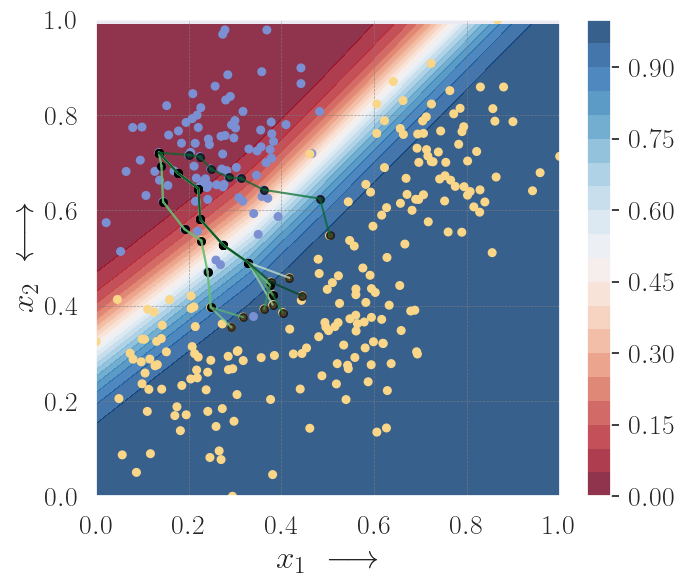

In [17]:
# node_path = [7, 3, 95, 18, 2, 33, 49, 177]
node_path = cf_solutions[start_point_idx][4]
fig, ax = plt.subplots(figsize=(7,6))
ax = plot_counterfactual_explanations(ax, df, clf, cf_solutions)
plt.tight_layout()
plt.savefig("../../../Latex_projects/ECML_PKDD_XKDD_workshop_paper/figures/cf_paths_id8.pdf", dpi=300, facecolor="white")

## k-means clustering and visualisation

In [12]:
n_clusters = 4
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=seed
)
kmeans.fit(X)
k_means_cluster_centers = kmeans.cluster_centers_
k_means_labels = kmeans.labels_
print(k_means_cluster_centers)

[[0.1989673  0.26168163]
 [0.74240436 0.70445514]
 [0.53510245 0.35999968]
 [0.26452641 0.70813616]]


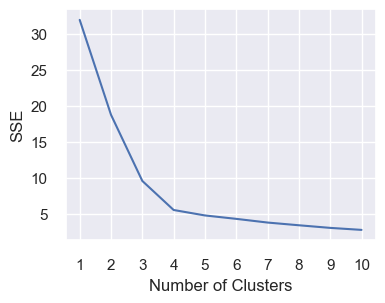

In [135]:
# determine the appropriate number of clusters
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(4,3))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [13]:
def get_cluster_sd(k_means_labels, X):
    labels = sorted(set(k_means_labels))
    sd_coords = []
    for label in labels:
        sds = X.loc[np.where(k_means_labels==label)].std()
        sd_coords.append((sds.x1, sds.x2))
    return sd_coords

def add_ellipse(mu_x1, mu_x2, sd_x1, sd_x2, ax, edge_color):
    # one SD contour
    ellipse_sd = mpl.patches.Ellipse((mu_x1, mu_x2), width=2*sd_x1, height=2*sd_x2, fc="none", edgecolor=edge_color, linestyle="--", label=r"$1\sigma$", linewidth=1.5)
    ax.add_patch(ellipse_sd)
    
    # two SD contour
    ellipse_2sd = mpl.patches.Ellipse((mu_x1, mu_x2), width=4*sd_x1, height=4*sd_x2, fc="none", edgecolor=edge_color, linestyle=":", label=r"$2\sigma$", linewidth=1.5)  
    ax.add_patch(ellipse_2sd)
    return ax

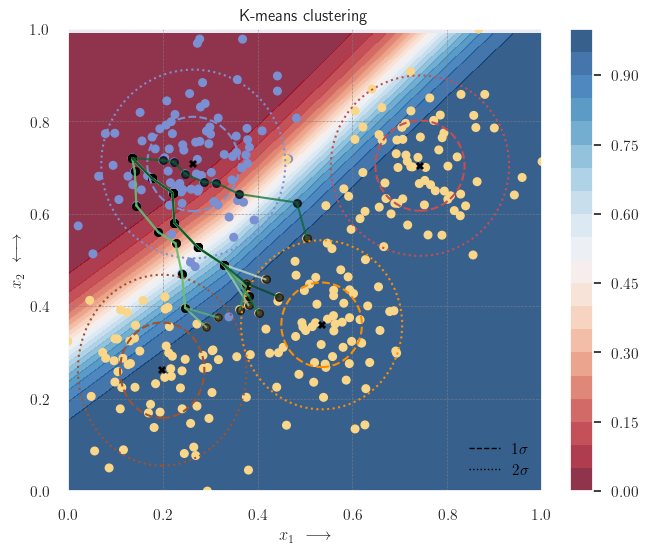

In [14]:
def plot_data_clustering(ax, k_means_cluster_centers, k_means_labels, diff_cluster=True):

    colors = ["sienna", "r", "#FAD689", "#7B90D2"]
    n_clusters = len(k_means_cluster_centers)
    for k, col in zip(range(n_clusters), colors):
        my_members = k_means_labels == k
        cluster_center = k_means_cluster_centers[k]
        if diff_cluster:
            ax.scatter(X.iloc[my_members, 0], X.iloc[my_members, 1], c=col)
        ax.plot(
            cluster_center[0],
            cluster_center[1],
            "X",
            markerfacecolor="black",
            markersize=6,
        )

    ax.set_title("K-means clustering")
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.grid(color="grey", linestyle = "--", linewidth= 0.5, alpha=0.75)
    ax.set_xlabel(r"$x_1~\longrightarrow$")
    ax.set_ylabel(r"$x_2~\longleftrightarrow$")

    contour_colors = ["sienna", "r", "darkorange", "#7B90D2"]
    sd_coords = get_cluster_sd(k_means_labels, X)
    for center_idx, mu in enumerate(k_means_cluster_centers):
        add_ellipse(mu[0], mu[1], sd_coords[center_idx][0], sd_coords[center_idx][1], ax, contour_colors[center_idx])

    legend_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                    Line2D([0], [0], color="black", lw=1, linestyle=":")]

    ax.legend(legend_lines, [r'$1\sigma$', r'$2\sigma$'], loc="lower right", labelcolor="black")

    return ax

fig, ax = plt.subplots(figsize=(7.2, 6))
ax = plot_counterfactual_explanations(ax, df, clf, cf_solutions)
ax = plot_data_clustering(ax, k_means_cluster_centers, k_means_labels, diff_cluster=False)
# ax = plot_data_clustering(ax, k_means_cluster_centers, k_means_labels)
plt.show(fig)

## Branching factors

In [20]:
def construct_alternative_paths(sp_graph, start_point_indices, end_point_indices):
    branching_dict = {}
    branch_dist = {}
    for start_point_idx in start_point_indices:
        branching_dict[start_point_idx] = {}
        branch_dist[start_point_idx] = {}
        for end_point_idx in end_point_indices:
            dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)
            if start_point_idx != end_point_idx:
                shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
            else:
                shortest_path = []
            branching_dict[start_point_idx][end_point_idx] = shortest_path
            branch_dist[start_point_idx][end_point_idx] = dist_matrix[end_point_idx]
    return branching_dict, branch_dist


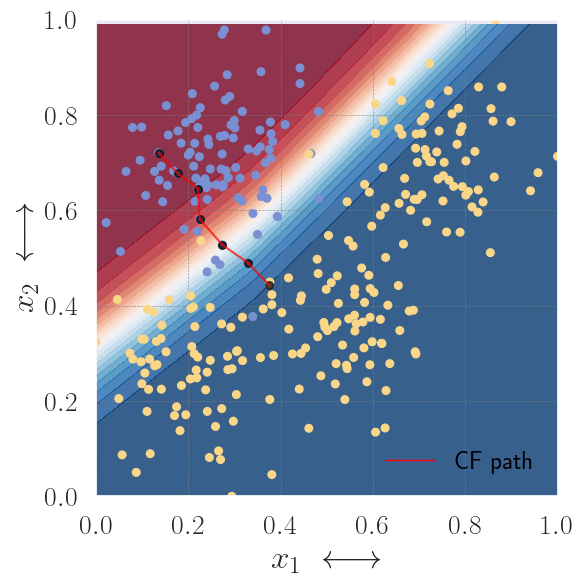

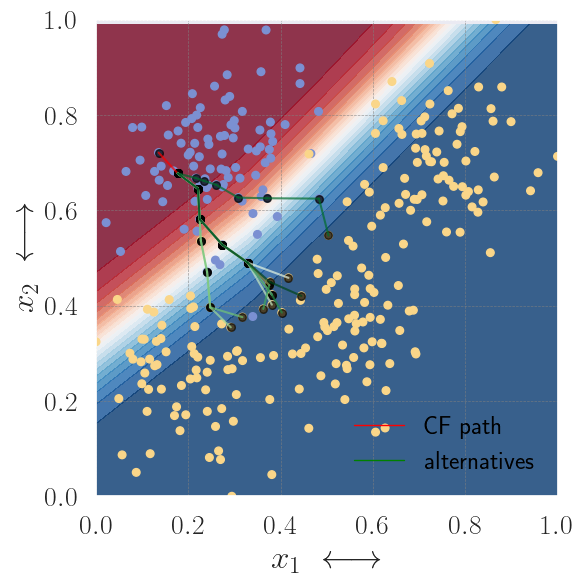

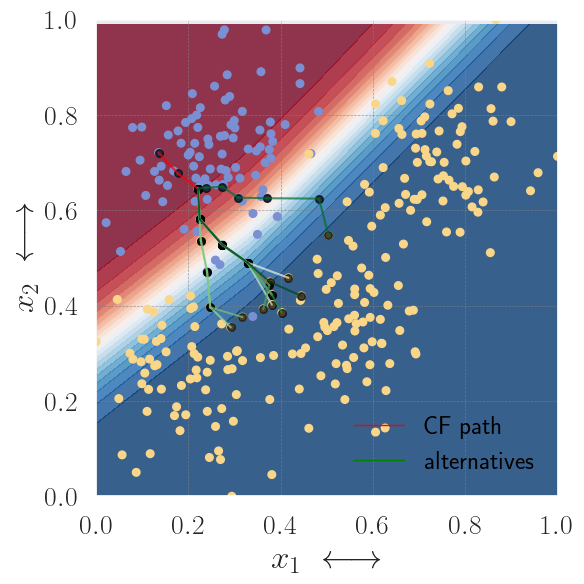

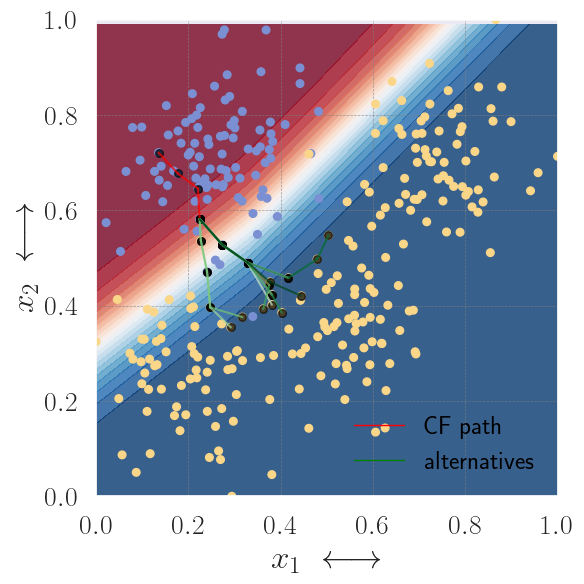

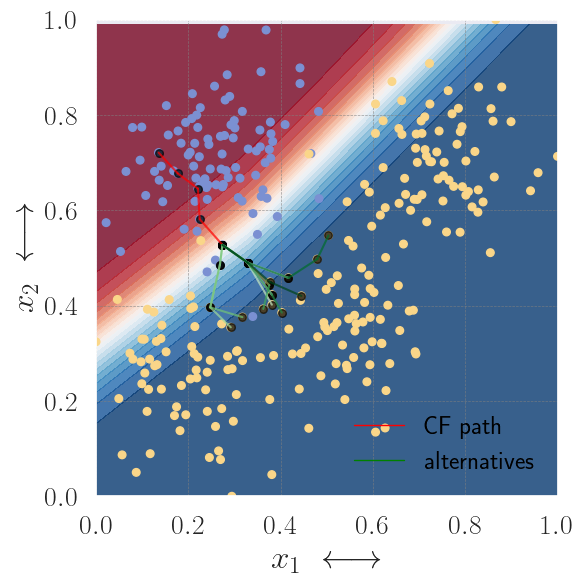

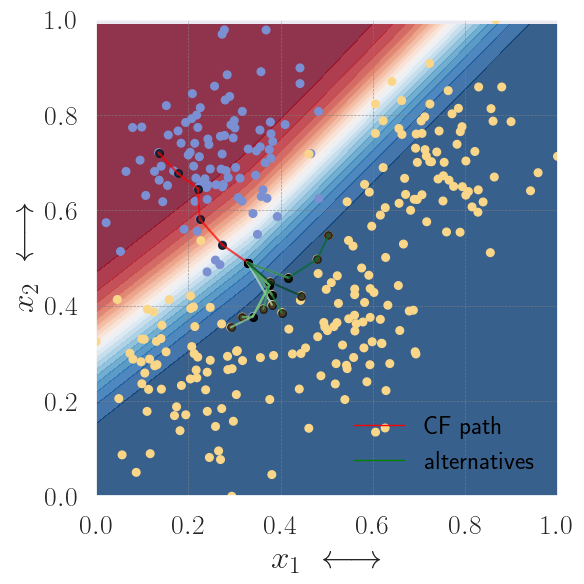

In [32]:
branching_dict, branch_dist = construct_alternative_paths(sp_graph, [87, 15, 65, 59, 49], [202, 232, 175, 157, 167, 124, 225, 235, 189])

main_path = [8, 87, 15, 65, 59, 49, 177]

fig, ax = plt.subplots(figsize=(6,6))
ax = plot_counterfactual_explanations(ax, df, clf, {8: {0: [8, 87, 15, 65, 59, 49, 177]}}, color_bar=False)
path_legend_lines = [Line2D([0], [0], color="red", lw=1), Line2D([0], [0], color="green", lw=1)]
ax.legend([path_legend_lines[0]], ["CF path"], loc="lower right", labelcolor="black", fontsize=18)
plt.tight_layout()
plt.savefig(f"{workshop_paper_path}cf_shortest_path_id8.pdf", dpi=300, facecolor="white")
plt.show()

for step_count, (k, v) in enumerate(branching_dict.items()):
    fig, ax = plt.subplots(figsize=(6,6))
    ax = plot_counterfactual_explanations(ax, df, clf, {k:v}, color_bar=False)
    ax = plot_one_path(ax, X, main_path, color="red", zorder=2)
    ax.legend(path_legend_lines, ["CF path", "alternatives"], loc="lower right", labelcolor = "black", fontsize=18)
    plt.tight_layout()
    # plt.savefig(f"{workshop_paper_path}cf_shortest_path_id8_step{step_count+1}.pdf", dpi=300, facecolor="white")
    plt.show()


In [18]:
# calculate the branching factor of each node
# Visualise the calculation
print(end_point_indices)
print(cf_solutions)
print(branch_dist)
print(end_point_indices[0:4] + end_point_indices[5:7])

[177, 202, 232, 175, 157, 167, 124, 225, 235, 189]
{8: {0: [8, 87, 15, 65, 59, 49, 177], 1: [8, 87, 15, 65, 59, 49, 202], 2: [8, 87, 15, 65, 59, 49, 232], 3: [8, 87, 15, 65, 59, 49, 175], 4: [8, 96, 39, 60, 206, 42, 109, 157], 5: [8, 96, 39, 60, 206, 42, 109, 167], 6: [8, 87, 15, 65, 59, 49, 177, 124], 7: [8, 87, 15, 65, 59, 49, 202, 225], 8: [8, 48, 77, 4, 18, 20, 99, 56, 235], 9: [8, 87, 15, 65, 59, 49, 220, 189]}}
{8: {177: 0.38443008579673166, 202: 0.40318120560647147, 232: 0.41189719570877614, 175: 0.42048981706366995, 167: 0.4355212660677764, 124: 0.4361103030986121, 225: 0.44646567422676414, 235: 0.45026457143964144, 189: 0.4550929044131924}, 96: {177: 0.35544509465400453, 202: 0.37419621446374435, 232: 0.382912204566049, 175: 0.3915048259209428, 167: 0.4064738887992453, 124: 0.40712531195588497, 225: 0.417480683084037, 235: 0.43526850004134904, 189: 0.42610791327046527}, 39: {177: 0.2959884597634529, 202: 0.31473957957319276, 232: 0.3234555696754974, 175: 0.3320481910303912, 16

In [25]:
def calculate_path_sum_branch_factor(branch_dist):
    sum_branch_factor = {}
    for node_idx, dist_dict in branch_dist.items():
        sum_branch_factor[node_idx] = 0
        for alter_node_idx, alter_dist in dist_dict.items():
            sum_branch_factor[node_idx] += alter_dist
    return sum_branch_factor

In [26]:
all_branch_factor = {}
for rank, node_path in cf_solutions[start_point_idx].items():
    alter_end_indices = list(set(end_point_indices) - set([node_path[-1]]))
    # alter_end_indices = [190, 116, 217]
    branching_dict, branch_dist = construct_alternative_paths(sp_graph, node_path[:-1], alter_end_indices)
    path_branch_factor = calculate_path_sum_branch_factor(branch_dist)
    all_branch_factor[rank] = path_branch_factor
print(all_branch_factor)

{0: {8: 3.882918402172347, 87: 3.351671941392533, 15: 2.8718236539513375, 65: 2.3715054962723436, 59: 1.753496506557839, 49: 1.2498972441488672}, 1: {8: 3.864167282362607, 87: 3.3329208215827935, 15: 2.8530725341415977, 65: 2.3527543764626038, 59: 1.7347453867480993, 49: 1.2311461243391273}, 2: {8: 3.855451292260302, 87: 3.324204831480489, 15: 2.844356544039293, 65: 2.344038386360299, 59: 1.7260293966457947, 49: 1.2224301342368227}, 3: {8: 3.8468586709054087, 87: 3.315612210125595, 15: 2.835763922684399, 65: 2.3354457650054057, 59: 1.7174367752909008, 49: 1.2138375128819288}, 4: {8: 3.843453023421636, 96: 3.596514636755722, 39: 3.100841164918062, 60: 2.4570625489655353, 206: 2.0807266819531645, 42: 1.8112086611659035, 109: 1.5586029578592318}, 5: {8: 3.831827221901302, 96: 3.5848888352353883, 39: 3.089215363397728, 60: 2.4454367474452017, 206: 2.069100880432831, 42: 1.7995828596455699, 109: 1.5469771563388979}, 6: {8: 3.8312381848704664, 87: 3.2999917240906522, 15: 2.820143436649457, 6

In [27]:
all_x = []
for rank, path_node in cf_solutions[start_point_idx].items():
    x_coords = []
    for node_idx in path_node:
        x_coords.append(dist_matrix[node_idx])
    all_x.append(x_coords)
print(all_x)

all_y = []
for rank, path_factor in all_branch_factor.items():
    y_coords = []
    for node_idx, factor_value in path_factor.items():
        y_coords.append(factor_value/9)
    y_coords.append(0)
    all_y.append(y_coords)
print(all_y)

[[0.0, 0.060341727465897506, 0.1144296611478012, 0.1785920430846077, 0.25174549938027946, 0.3175561266212029, 0.38443008579673166], [0.0, 0.060341727465897506, 0.1144296611478012, 0.1785920430846077, 0.25174549938027946, 0.3175561266212029, 0.40318120560647147], [0.0, 0.060341727465897506, 0.1144296611478012, 0.1785920430846077, 0.25174549938027946, 0.3175561266212029, 0.41189719570877614], [0.0, 0.060341727465897506, 0.1144296611478012, 0.1785920430846077, 0.25174549938027946, 0.3175561266212029, 0.42048981706366995], [0.0, 0.029047377268531054, 0.10363635123762692, 0.17761265157158226, 0.22100022542720626, 0.2880172429195613, 0.3627263177739715, 0.42389546454744254], [0.0, 0.029047377268531054, 0.10363635123762692, 0.17761265157158226, 0.22100022542720626, 0.2880172429195613, 0.3627263177739715, 0.4355212660677764], [0.0, 0.060341727465897506, 0.1144296611478012, 0.1785920430846077, 0.25174549938027946, 0.3175561266212029, 0.38443008579673166, 0.4361103030986121], [0.0, 0.06034172746

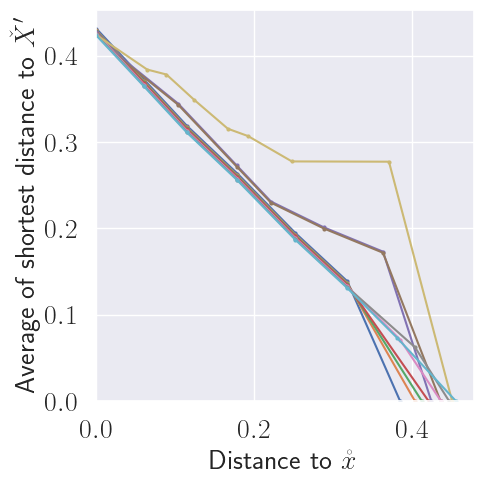

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
for path_idx in range(len(all_x)):
    ax.plot(all_x[path_idx], all_y[path_idx], marker=".")
    # ax.plot(all_x[1], all_y[1], marker=".")
ax.set_xlim(0,)
ax.set_ylim(0,)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r"Distance to $\mathring{x}$", fontsize=20)
ax.set_ylabel(r"Average of shortest distance to $\check{X}^{\prime}$", fontsize=20)
plt.tight_layout()
plt.savefig("../../../Latex_projects/ECML_PKDD_XKDD_workshop_paper/figures/undirected_path_avg_dist.pdf", dpi=300, facecolor="white")

### Number of paths accessible

In [78]:
def calculate_num_accessible_paths(sp_graph, start_point_indices, end_point_indices):
    num_accessible_paths = {}
    accessible_path_dict = {}
    for start_point_idx in start_point_indices:
        num_accessible_paths[start_point_idx] = 0
        accessible_path_dict[start_point_idx] = {}
        count = 0
        for end_point_idx in end_point_indices:
            dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)
            
            try:
                shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
                count += 1
                accessible_path_dict[start_point_idx][end_point_idx] = shortest_path
            except:
                pass
            
        num_accessible_paths[start_point_idx] = count
        
    return num_accessible_paths, accessible_path_dict

In [66]:
all_branch_factor = {}
for rank, node_path in cf_solutions[start_point_idx].items():
    alter_end_indices = list(set(end_point_indices) - set([node_path[-1]]))
    path_count_dict, _ = calculate_num_accessible_paths(sp_graph, node_path, alter_end_indices)
    all_branch_factor[rank] = path_count_dict
print(all_branch_factor)

{0: {8: 9, 21: 9, 83: 9, 65: 9, 59: 7, 177: 6}, 1: {8: 9, 87: 6, 57: 6, 71: 6, 2: 6, 33: 6, 232: 3}, 2: {8: 9, 21: 9, 83: 9, 65: 9, 59: 7, 49: 7, 202: 5}, 3: {8: 9, 96: 9, 39: 9, 60: 9, 50: 9, 167: 8}, 4: {8: 9, 48: 6, 4: 6, 18: 6, 31: 3, 19: 3, 235: 0}, 5: {8: 9, 96: 9, 39: 9, 60: 9, 206: 9, 42: 9, 157: 9}, 6: {8: 9, 87: 6, 57: 6, 71: 6, 2: 6, 9: 3, 228: 2}, 7: {8: 9, 21: 9, 83: 9, 65: 9, 59: 7, 49: 7, 175: 5}, 8: {8: 9, 21: 9, 83: 9, 65: 9, 59: 7, 49: 7, 124: 7}, 9: {8: 9, 87: 6, 57: 6, 71: 6, 2: 6, 9: 3, 190: 1}}


In [68]:
all_x = []
for rank, path_node in cf_solutions[start_point_idx].items():
    x_coords = []
    for node_idx in path_node:
        x_coords.append(dist_matrix[node_idx])
    all_x.append(x_coords)
print(all_x)

all_y = []
for rank, path_factor in all_branch_factor.items():
    y_coords = []
    for node_idx, factor_value in path_factor.items():
        y_coords.append(factor_value)
    # y_coords.append(0)
    all_y.append(y_coords)
print(all_y)

[[0.0, 0.07160475603611018, 0.13981722860046952, 0.17849772379022408, 0.2516511800858958, 0.3837477095608603], [0.0, 0.060341727465897506, 0.10078024722300932, 0.13056874536581256, 0.20137512230282595, 0.2890356269701232, 0.40236528506145985], [0.0, 0.07160475603611018, 0.13981722860046952, 0.17849772379022408, 0.2516511800858958, 0.3174618073268193, 0.40308688631208783], [0.0, 0.029047377268531054, 0.10363635123762692, 0.17761265157158226, 0.2713842355644168, 0.40466751600812423], [0.0, 0.06443081325858366, 0.12037015393177775, 0.163192156232914, 0.24500776142551745, 0.2580942611328594, 0.41259317755181163], [0.0, 0.029047377268531054, 0.10363635123762692, 0.17761265157158226, 0.22100022542720626, 0.2880172429195613, 0.41512238086425735], [0.0, 0.060341727465897506, 0.10078024722300932, 0.13056874536581256, 0.20137512230282595, 0.2949367978506603, 0.4192757094286033], [0.0, 0.07160475603611018, 0.13981722860046952, 0.17849772379022408, 0.2516511800858958, 0.3174618073268193, 0.4203954

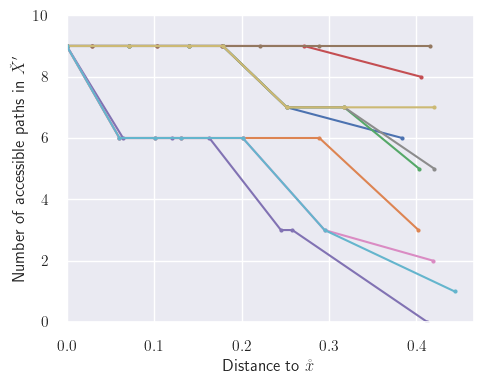

In [77]:
fig, ax = plt.subplots(figsize=(5,4))
for path_idx in range(len(all_x)):
    ax.plot(all_x[path_idx], all_y[path_idx], marker=".")
    # ax.plot(all_x[1], all_y[1], marker=".")
ax.set_xlim(0,)
ax.set_ylim(0, len(end_point_indices))
ax.set_xlabel(r"Distance to $\mathring{x}$")
ax.set_ylabel(r"Number of accessible paths in $\check{X}^{\prime}$")
plt.tight_layout()
plt.savefig("../../../Latex_projects/ECML_PKDD_XKDD_workshop_paper/figures/directed_path_accessible_count.pdf", dpi=300, facecolor="white")
plt.show()

In [84]:
single_path_count, single_path_alter = calculate_num_accessible_paths(sp_graph, [8, 48, 4, 18, 31, 19, 235], end_point_indices = [177, 232, 202, 167, 157, 228, 175, 124, 190])
print(single_path_alter)
print(single_path_count)


{8: {177: [8, 21, 83, 65, 59, 177], 232: [8, 87, 57, 71, 2, 33, 232], 202: [8, 21, 83, 65, 59, 49, 202], 167: [8, 96, 39, 60, 50, 167], 157: [8, 96, 39, 60, 206, 42, 157], 228: [8, 87, 57, 71, 2, 9, 228], 175: [8, 21, 83, 65, 59, 49, 175], 124: [8, 21, 83, 65, 59, 49, 124], 190: [8, 87, 57, 71, 2, 9, 190]}, 48: {177: [48, 4, 55, 2, 33, 177], 232: [48, 4, 55, 2, 33, 232], 202: [48, 4, 55, 2, 33, 202], 228: [48, 4, 55, 2, 9, 228], 175: [48, 4, 55, 2, 33, 175], 190: [48, 4, 55, 2, 9, 190]}, 4: {177: [4, 55, 2, 33, 177], 232: [4, 55, 2, 33, 232], 202: [4, 55, 2, 33, 202], 228: [4, 55, 2, 9, 228], 175: [4, 55, 2, 33, 175], 190: [4, 55, 2, 9, 190]}, 18: {177: [18, 2, 33, 177], 232: [18, 2, 33, 232], 202: [18, 2, 33, 202], 228: [18, 31, 9, 228], 175: [18, 2, 33, 175], 190: [18, 31, 9, 190]}, 31: {232: [31, 9, 232], 228: [31, 9, 228], 190: [31, 9, 190]}, 19: {232: [19, 9, 232], 228: [19, 9, 228], 190: [19, 9, 190]}, 235: {}}
{8: 9, 48: 6, 4: 6, 18: 6, 31: 3, 19: 3, 235: 0}


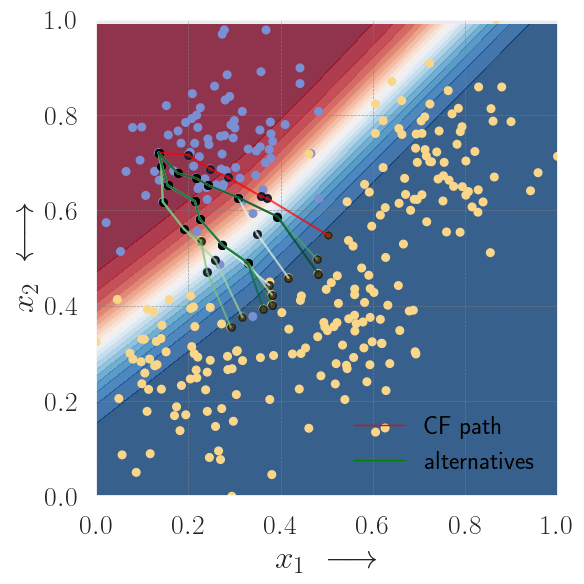

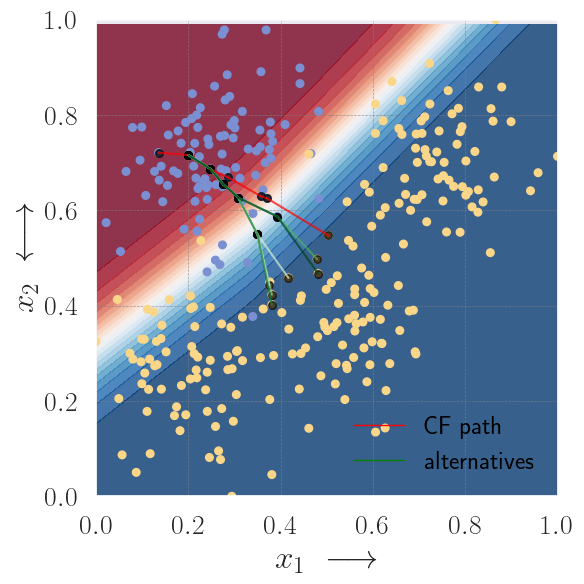

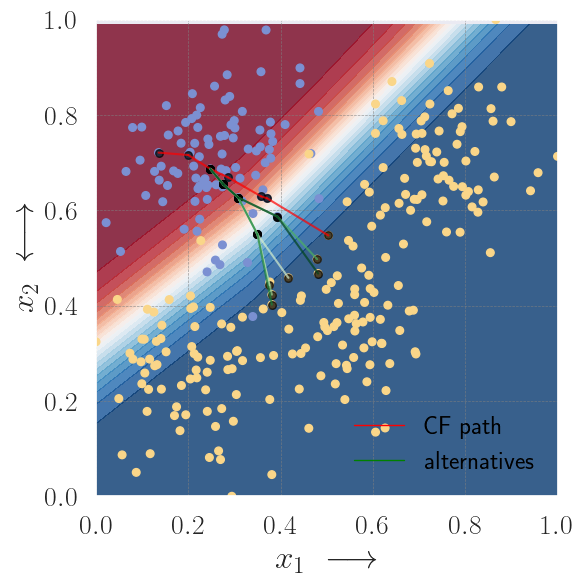

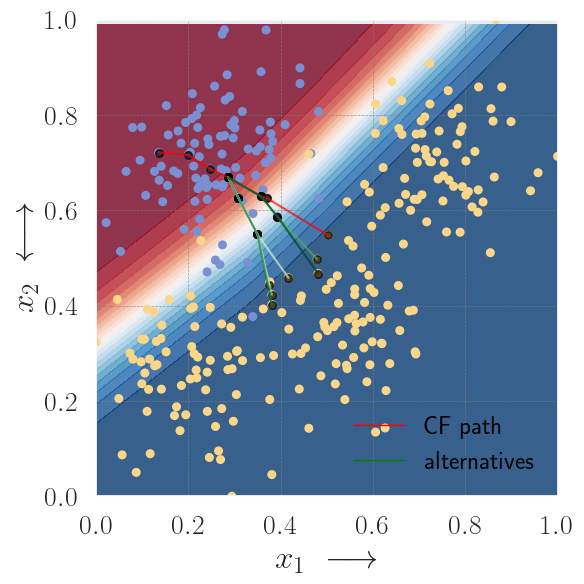

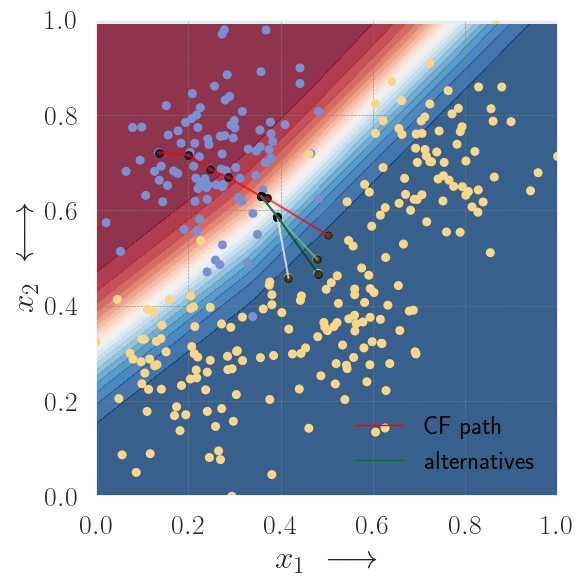

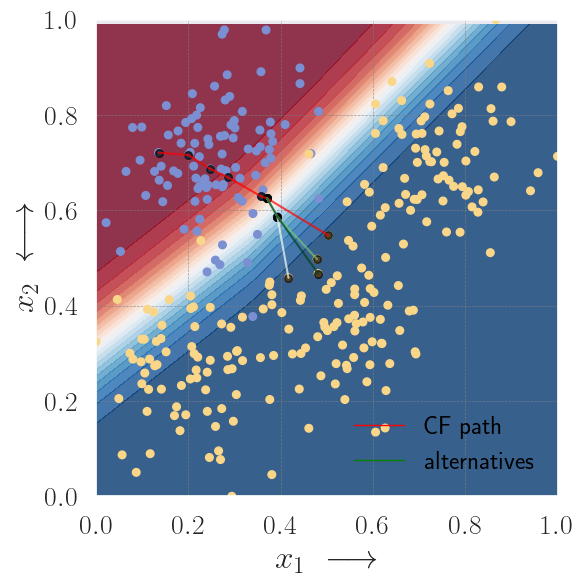

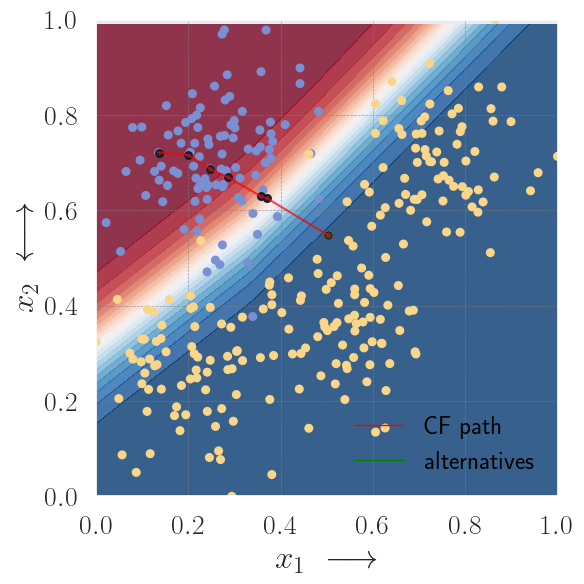

In [96]:
main_path = [8, 48, 4, 18, 31, 19, 235]
for step_count, (k, v) in enumerate(single_path_alter.items()):
    fig, ax = plt.subplots(figsize=(6,6))
    ax = plot_counterfactual_explanations(ax, df, clf, {k:v}, color_bar=False)
    ax = plot_one_path(ax, X, main_path, color="red", zorder=2)
    ax.legend(path_legend_lines, ["CF path", "alternatives"], loc="lower right", labelcolor = "black", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{workshop_paper_path}cf_shortest_path_id8_directed_step{step_count+1}.pdf", dpi=300, facecolor="white")
    plt.show()